# Machine Learning for San Diego

In [1]:
# Standard Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
import glob

import warnings
warnings.filterwarnings('ignore')

# Word Cloud
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
path = 'C:/Users/Ryan/Documents/Github/ML-SD-Project/'
#path = 'C:/Users/Ryan Luu/Documents/Github/ML-SD-Project/'

all_files = glob.glob(path + "data/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

raw = pd.concat(li, axis=0, ignore_index=True)

In [3]:
raw.head()

,service_request_id,service_request_parent_id,sap_notification_number,date_requested,case_age_days,service_name,case_record_type,date_updated,status,lat,lng,council_district,comm_plan_code,comm_plan_name,park_name,case_origin,referred,public_description
0,80477,NaN,NaN,2016-05-20T00:08:00,15.0,Other,TSW,2016-06-03T00:00:00,Closed,NaN,NaN,NaN,NaN,NaN,NaN,Email,NaN,Name : JackEmail : bcjack@hotmail.comAddress...
1,80478,NaN,NaN,2016-05-20T05:04:00,NaN,Parking Meter,TSW,NaN,Referred,32.726553,-117.125296,3.0,8.0,Greater Golden Hill,NaN,Mobile,NaN,NaN
2,80479,NaN,NaN,2016-05-20T05:05:00,NaN,72 Hour Violation,Parking,NaN,Referred,32.726523,-117.125532,3.0,8.0,Greater Golden Hill,NaN,Mobile,NaN,NaN
3,80480,NaN,NaN,2016-05-20T05:05:00,NaN,Dead Animal,TSW,NaN,Referred,32.726365,-117.125478,3.0,8.0,Greater Golden Hill,NaN,Mobile,NaN,NaN
4,80481,NaN,NaN,2016-05-20T05:06:00,0.0,Graffiti Removal,TSW,2016-05-20T00:00:00,Closed,32.726445,-117.125476,3.0,8.0,Greater Golden Hill,NaN,Mobile,NaN,Test


In [4]:
print("There are " + str(raw.shape[0]) + " observations and " + str(raw.shape[1]) + " variables.")

There are 681427 observations and 18 variables.


# Data Cleaning and Manipulation

In [5]:
# Remove unnecessary columns
raw = raw.drop(["service_request_id", "service_request_parent_id", "sap_notification_number",'referred'], axis=1)

In [6]:
df = raw
# Convert back into datetime64
df['date_requested'] = pd.to_datetime(df['date_requested'])

# Extract date, month, time
df['date'] = df.date_requested.dt.date 
df['month'] = df.date_requested.dt.month
df['time'] = df.date_requested.dt.time

# Better Season
def gs(x):
    if (x == 12) or (x < 3):
        return 'Winter'
    elif (x >= 3) and (x < 6):
        return 'Spring'
    elif (x >= 6) and (x < 9):
        return 'Summer'
    elif (x >= 9) and (x < 12):
        return 'Fall'
    else: 
        return 'Error'

df['season'] = df.month.apply(lambda x: gs(x))

# Time of the Day Variable
def gt(x):
    if (x >= 0) and (x <= 5):
        return 'Past Midnight'
    elif (x > 5) and (x <= 11):
        return 'Morning'
    elif (x > 11) and (x <= 17):
        return 'Afternoon'
    elif (x > 17) and (x <= 23):
        return 'Evening'

df['tod'] = df.date_requested.dt.hour.apply(lambda x: gt(x))

# Make new DOW (day of week) variable
df['dow'] = df.date.apply(lambda x: pd.Timestamp(str(x)).weekday_name)

# Lowercase public description
df.public_description = df.public_description.apply(lambda x: str(x).lower())

# Month 
df.month[df.month == 1] = 'Jan'
df.month[df.month == 2] = 'Feb'
df.month[df.month == 3] = 'Mar'
df.month[df.month == 4] = 'Apr'
df.month[df.month == 5] = 'May'
df.month[df.month == 6] = 'Jun'
df.month[df.month == 7] = 'Jul'
df.month[df.month == 8] = 'Aug'
df.month[df.month == 9] = 'Jan'
df.month[df.month == 10] = 'Oct'
df.month[df.month == 11] = 'Nov'
df.month[df.month == 12] = 'Dec'

#Cleaning and replacing nan in council district with 0
df['council_district'] = df.council_district.fillna(0)
df['council_district'] = df.council_district.astype(np.int64)
df['council_district'] = df.council_district.apply(lambda x: 'district ' + str(x))

# Remove 'Test' observations from public description
df = df[~df.public_description.str.contains('test')]

# Cleaning and Remove nan obsertation in case age days
df = df.dropna(subset=['case_age_days'])
df['case_age_days'] = df.case_age_days.astype(np.int64)

# Setting Conditions for Dataframe
df['lat'] = df['lat'].astype(float)
df['lng'] = df['lng'].astype(float)
df2 = df[(df['lat'] > 32.5444) &
        (df['lat'] < 33.4274) &
        (df['lng'] < -117.0301) &
        (df['lng'] > -117.6126) &
        (df['status'] == 'Closed')]

df2.tail()

,date_requested,case_age_days,service_name,case_record_type,date_updated,status,lat,lng,council_district,comm_plan_code,comm_plan_name,park_name,case_origin,public_description,date,month,time,season,tod,dow
681420,2019-12-31 23:08:00,1,NaN,Parking,2020-01-02T00:00:00,Closed,32.799915,-117.244770,district 2,27.0,Pacific Beach,NaN,Mobile,fireworks in the joint use field on or around ..,2019-12-31,Dec,23:08:00,Winter,Evening,Tuesday
681422,2019-12-31 23:28:00,1,Citizen Contact,Parking,2020-01-02T00:00:00,Closed,32.707425,-117.093231,district 4,11.0,Encanto Neighborhoods,NaN,Mobile,loud fireworks and loud music coming fromel re...,2019-12-31,Dec,23:28:00,Winter,Evening,Tuesday
681423,2019-12-31 23:32:00,6,72 Hour Violation,Parking,2020-01-07T00:00:00,Closed,32.767174,-117.122808,district 3,59.0,Mid-City:Normal Heights,NaN,Mobile,car has been parked for at least two weeks in ...,2019-12-31,Dec,23:32:00,Winter,Evening,Tuesday
681424,2019-12-31 23:35:00,1,Citizen Contact,Parking,2020-01-02T00:00:00,Closed,32.751146,-117.250123,district 2,23.0,Ocean Beach,NaN,Mobile,apartment residents are throwing fireworks at ...,2019-12-31,Dec,23:35:00,Winter,Evening,Tuesday
681425,2019-12-31 23:45:00,2,Illegal Dumping,ESD Complaint/Report,2020-01-03T00:00:00,Closed,32.709147,-117.059223,district 4,11.0,Encanto Neighborhoods,NaN,Mobile,nan,2019-12-31,Dec,23:45:00,Winter,Evening,Tuesday


In [7]:
#df2.to_csv(path + "data/get_it_done_full.csv", encoding='utf-8', index=False)

# Exploratory Data Analysis

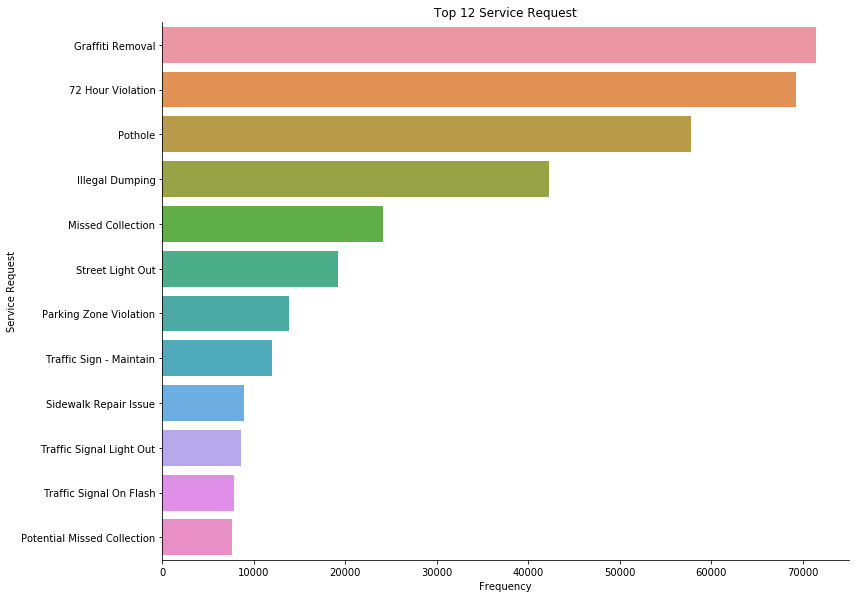

In [8]:
a= sns.catplot(y = 'service_name',
           kind = 'count',
           height = 8,
           aspect = 1.5,
           order = df2.service_name.value_counts().head(12).index,
           data = df2)
plt.title("Top 12 Service Request")
a.set(xlabel='Frequency', ylabel='Service Request')

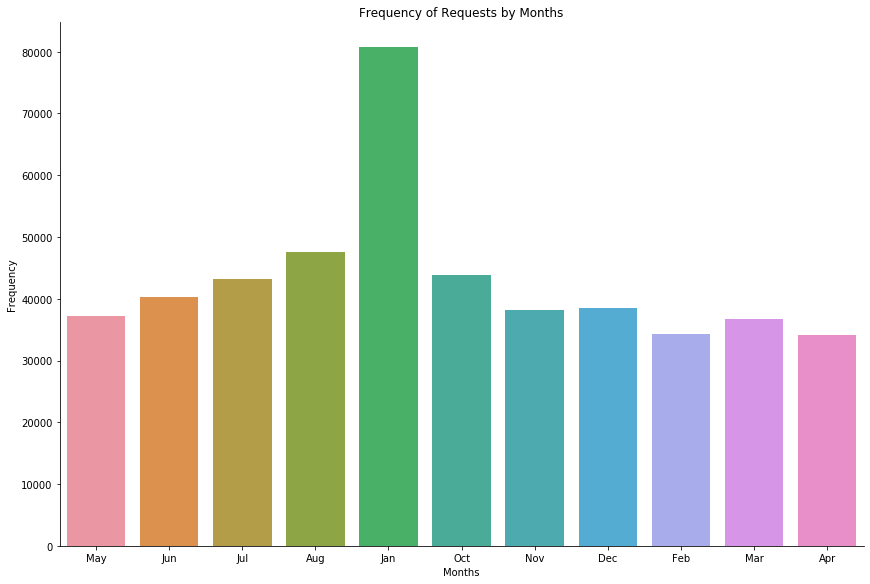

In [9]:
a = sns.catplot(x='month',
            kind='count',
            height=8, 
            aspect=1.5,
            data=df2)

plt.title("Frequency of Requests by Months")
a.set(xlabel="Months",ylabel="Frequency")
plt.show()

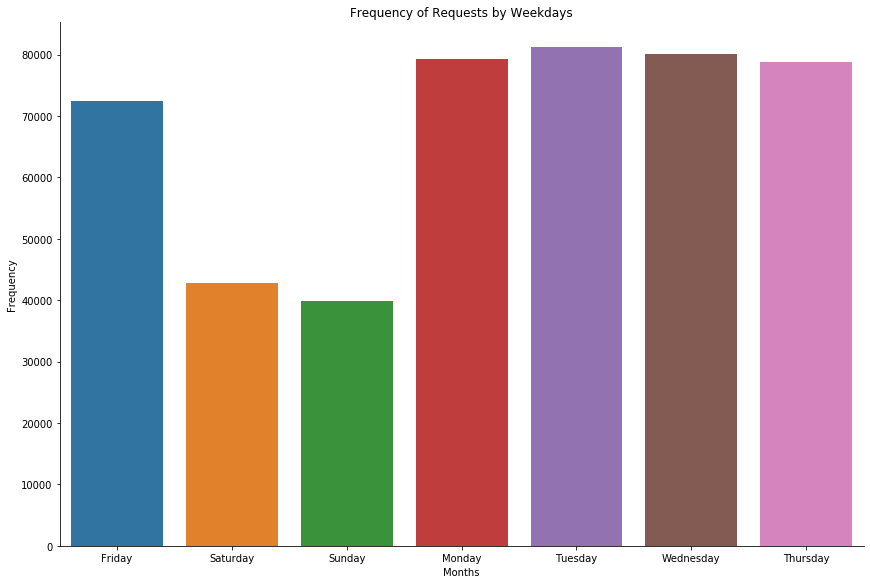

In [10]:
a = sns.catplot(x='dow',
            kind='count',
            height=8, 
            aspect=1.5,
            data=df2)

plt.title("Frequency of Requests by Weekdays")
a.set(xlabel="Months",ylabel="Frequency")
plt.show()

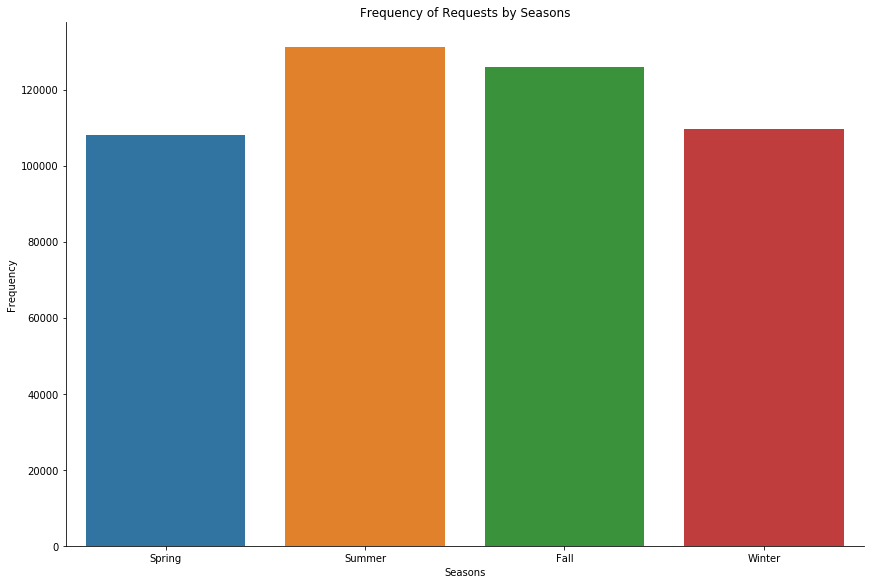

In [11]:
a = sns.catplot(x='season',
            kind='count',
            height=8, 
            aspect=1.5,
            data=df2)

plt.title("Frequency of Requests by Seasons")
a.set(xlabel="Seasons",ylabel="Frequency")
plt.show()

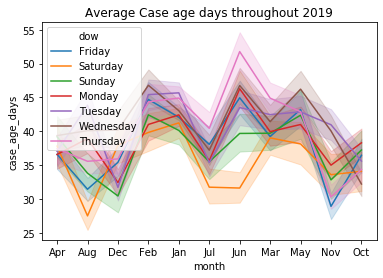

In [12]:
c = sns.lineplot(x="month",
                y="case_age_days",
                hue='dow',
                data=df2
                ).set_title('Average Case age days throughout 2019')
plt.show()

# WordCloud

In [13]:
# Clean nan from public description
desc = ((df2[~df2.public_description.str.contains('nan')])['public_description'])
string = desc.to_string()

In [14]:
s = stopwords.words('english')
print(s)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

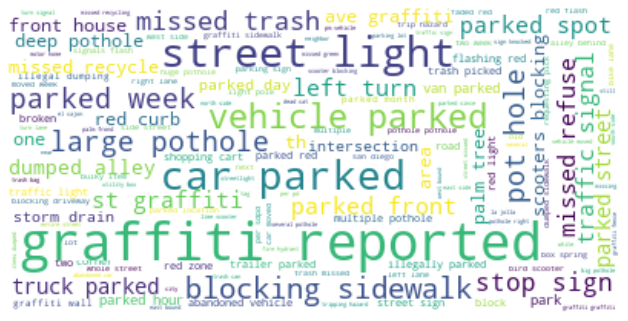

In [15]:
wordcloud = WordCloud(stopwords = s, background_color='white').generate(string)

# Plot
plt.figure(figsize=(11,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Preparing New Dataframe

In [16]:
df2.head()

,date_requested,case_age_days,service_name,case_record_type,date_updated,status,lat,lng,council_district,comm_plan_code,comm_plan_name,park_name,case_origin,public_description,date,month,time,season,tod,dow
17,2016-05-20 07:19:00,14,Graffiti Removal,TSW,2016-06-03T00:00:00,Closed,32.735047,-117.080075,district 4,57.0,Mid-City:Eastern Area,NaN,Phone,graffiti on the wall in front of the library,2016-05-20,May,07:19:00,Spring,Morning,Friday
32,2016-05-20 09:07:00,0,Damaged Curb,TSW,2016-05-20T00:00:00,Closed,32.747350,-117.128953,district 3,28.0,North Park,NaN,Mobile,nan,2016-05-20,May,09:07:00,Spring,Morning,Friday
33,2016-05-20 09:10:00,537,Storm Water Code Enforcement - Illegal Discharge,TSW,2017-11-08T00:00:00,Closed,32.801410,-117.233518,district 2,27.0,Pacific Beach,NaN,Phone,nan,2016-05-20,May,09:10:00,Spring,Morning,Friday
36,2016-05-20 09:20:00,6,Traffic Sign - Maintain,TSW,2016-05-26T00:00:00,Closed,32.913842,-117.113892,district 5,34.0,Scripps Miramar Ranch,NaN,Phone,construction sign face down in center medien,2016-05-20,May,09:20:00,Spring,Morning,Friday
37,2016-05-20 09:24:00,987,Evaluate for Resurfacing,TSW,2019-01-31T00:00:00,Closed,32.919712,-117.114320,district 5,34.0,Scripps Miramar Ranch,NaN,Phone,lots of cracks and missing asphalt,2016-05-20,May,09:24:00,Spring,Morning,Friday


In [17]:
# Normalize function
def norm(x):
    r = (x-min(x))/(max(x)-min(x))
    return(r)

In [18]:
# Convert into categorical
df2['season'] = df['season'].astype('category')
df2['dow'] = df['dow'].astype('category')
df2['case_record_type'] = df['case_record_type'].astype('category')
df2['council_district'] = df['council_district'].astype('category')
df2['month'] = df['month'].astype('category')
df2['case_origin'] = df['case_origin'].astype('category')
df2['service_name'] = df['service_name'].astype('category')

In [19]:
df3 = pd.get_dummies(df2, columns=['dow'], prefix = [None])
df3 = pd.get_dummies(df3, columns=['month'], prefix = [None])
df3 = pd.get_dummies(df3, columns=['season'], prefix = [None])
df3 = pd.get_dummies(df3, columns=['council_district'], prefix = [None])
df3 = pd.get_dummies(df3, columns =['case_origin'], prefix = [None])
df3 = pd.get_dummies(df3, columns = ['comm_plan_name'], prefix = [None])
df3 = pd.get_dummies(df3, columns = ['tod'], prefix = [None])

df3['normLat'] = norm(df3.lat)
df3['normLng'] = norm(df3.lng)

df3.head()

,date_requested,case_age_days,service_name,case_record_type,date_updated,status,lat,lng,comm_plan_code,park_name,...,Torrey Pines,University,Uptown,Via De La Valle,Afternoon,Evening,Morning,Past Midnight,normLat,normLng
17,2016-05-20 07:19:00,14,Graffiti Removal,TSW,2016-06-03T00:00:00,Closed,32.735047,-117.080075,57.0,NaN,...,0,0,0,0,0,0,1,0,0.252822,0.858126
32,2016-05-20 09:07:00,0,Damaged Curb,TSW,2016-05-20T00:00:00,Closed,32.747350,-117.128953,28.0,NaN,...,0,0,0,0,0,0,1,0,0.269138,0.719367
33,2016-05-20 09:10:00,537,Storm Water Code Enforcement - Illegal Discharge,TSW,2017-11-08T00:00:00,Closed,32.801410,-117.233518,27.0,NaN,...,0,0,0,0,0,0,1,0,0.340828,0.422515
36,2016-05-20 09:20:00,6,Traffic Sign - Maintain,TSW,2016-05-26T00:00:00,Closed,32.913842,-117.113892,34.0,NaN,...,0,0,0,0,0,0,1,0,0.489928,0.762122
37,2016-05-20 09:24:00,987,Evaluate for Resurfacing,TSW,2019-01-31T00:00:00,Closed,32.919712,-117.114320,34.0,NaN,...,0,0,0,0,0,0,1,0,0.497712,0.760908


In [20]:
# Drop column not needed for training
df3 = df3.drop(["date_requested", "case_age_days", "service_name",'date_updated', 'status',
                'lat','lng','comm_plan_code','park_name',
               'public_description','date','time'], axis=1)

In [21]:
df3.head()

,case_record_type,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Apr,Aug,...,Torrey Pines,University,Uptown,Via De La Valle,Afternoon,Evening,Morning,Past Midnight,normLat,normLng
17,TSW,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.252822,0.858126
32,TSW,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.269138,0.719367
33,TSW,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.340828,0.422515
36,TSW,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.489928,0.762122
37,TSW,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.497712,0.760908


In [22]:
# View unique classes
df3.case_record_type.unique()

[TSW, Parking, ESD Complaint/Report, Traffic Engineering, DSD, TSW ROW, Storm Water Code Enforcement]
Categories (7, object): [TSW, Parking, ESD Complaint/Report, Traffic Engineering, DSD, TSW ROW, Storm Water Code Enforcement]

In [23]:
# Convert case_record_type into integer category
def dep(x):
    if x == 'TSW':
        return 0
    if x == 'Parking':
        return 1
    if x == 'ESD Complaint/Report':
        return 2
    if x == 'Traffic Engineering':
        return 3
    if x == 'DSD':
        return 4
    if x == 'TSW ROW':
        return 5
    if x == 'Storm Water Code Enforcement':
        return 6
    
df3.case_record_type = df3.case_record_type.apply(lambda x: dep(x))

In [24]:
df3.tail()

,case_record_type,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Apr,Aug,...,Torrey Pines,University,Uptown,Via De La Valle,Afternoon,Evening,Morning,Past Midnight,normLat,normLng
681420,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0.338846,0.390570
681422,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0.216192,0.820778
681423,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0.295427,0.736812
681424,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0.274173,0.375375
681425,2,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0.218476,0.917324


# Machine Learning Time!

#### Packages

In [25]:
# ML Packages
import tensorflow as tf
from tensorflow import keras

import scipy
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from collections import Counter

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

#### Test and Train Split 

Hold-out method: Create train and test sets. Train the model with the train set and test on test set.

In [26]:
np.random.seed(1234)

split = np.random.rand(len(df3)) < 0.7
train = df3[split]
test = df3[~split]

In [27]:
# Change train into np.array since Tensorflow works w array & convert to float
train_nparray = train.values

trainx = (train_nparray[:,1:]).astype('float32')
trainy = train_nparray[:,[0]].astype('float32')

In [28]:
# Change test into np.array since Tensorflow works w array & convert to float
test_nparray = test.values

testx = (test_nparray[:,1:]).astype('float32')
testy = (test_nparray[:,[0]]).astype('float32')

#### Functions

In [29]:
# Accuracy Report
def cm_report(x,y):
    print('Accuracy Score: ', accuracy_score(x,y))
    print()
    print('Report')
    print(classification_report(x,y))

labels = ['TSW 0', 'Parking 1', 'ESD Complaint/Report 2', 'Traffic Engineering 3',
          'DSD 4', 'TSW ROW 5', 'Storm Water Code Enforcement 6']

# Prediction Report    
def pred_report(x):
    print('Prediction Report')
    print('')
    prediction = x.predict_proba(testx)
    predictiondf = pd.DataFrame(data=prediction)
    predictiondf.rename(columns={i:j for i,j in zip(predictiondf.columns,labels)}, inplace = True)
    predictiondf['Class_Prediction'] = [labels[np.argmax(i)] for i in prediction]
    predictiondf['Pred'] = [int(labels[np.argmax(i)][-1:]) for i in prediction]
    predictiondf['Prob'] = [np.max(i) for i in prediction]
    predictiondf['Actual'] = testy.astype(int)
    predictiondf['Score'] = np.where(predictiondf.Actual == predictiondf.Pred, True, False)
    print(predictiondf.head(10))
    print('')
    
    predict = predictiondf.Pred.values
    actual = predictiondf.Actual.values
    cm_report(actual,predict)

# Neural Network

In [30]:
nn_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(125, )),
    keras.layers.Dense(128, activation=tf.nn.relu), #Rectified linear unit, common activation function
    #keras.layers.Dense(1, activation=tf.nn.relu),
    keras.layers.Dense(7, activation=tf.nn.softmax) # 7 classes in predicting service request type
])

nn_model.compile(optimizer='adam',
             loss = 'sparse_categorical_crossentropy', # multiclass prediction
             metrics=['accuracy'])

In [31]:
nn_model.fit(trainx, trainy, epochs=10)

Train on 332555 samples
Epoch 1/10
332555/332555 [==============================] - 8s 23us/sample - loss: 0.8910 - accuracy: 0.6342
Epoch 2/10
332555/332555 [==============================] - 7s 22us/sample - loss: 0.8651 - accuracy: 0.6436
Epoch 3/10
332555/332555 [==============================] - 7s 22us/sample - loss: 0.8600 - accuracy: 0.6450
Epoch 4/10
332555/332555 [==============================] - 7s 22us/sample - loss: 0.8563 - accuracy: 0.6469
Epoch 5/10
332555/332555 [==============================] - 7s 22us/sample - loss: 0.8537 - accuracy: 0.6482
Epoch 6/10
332555/332555 [==============================] - 7s 22us/sample - loss: 0.8515 - accuracy: 0.6489
Epoch 7/10
332555/332555 [==============================] - 8s 23us/sample - loss: 0.8500 - accuracy: 0.6493
Epoch 8/10
332555/332555 [==============================] - 7s 22us/sample - loss: 0.8483 - accuracy: 0.6499
Epoch 9/10
332555/332555 [==============================] - 7s 22us/sample - loss: 0.8471 - accuracy: 0.

In [32]:
train_loss, train_acc = nn_model.evaluate(trainx, trainy)

print('Train accuracy:', train_acc)

332555/332555 [==============================] - 4s 13us/sample - loss: 0.8393 - accuracy: 0.6530
Train accuracy: 0.6530168


In [33]:
test_loss, test_acc = nn_model.evaluate(testx, testy)

print('Test accuracy:', test_acc)

141979/141979 [==============================] - 2s 13us/sample - loss: 0.8598 - accuracy: 0.6449
Test accuracy: 0.6449123


In [34]:
pred_report(nn_model)

Prediction Report

      TSW 0  Parking 1  ESD Complaint/Report 2  Traffic Engineering 3  \
0  0.865210   0.001258                0.122649               0.007983   
1  0.864536   0.001247                0.123153               0.008114   
2  0.430816   0.001136                0.565360               0.001727   
3  0.725931   0.000573                0.030896               0.035258   
4  0.754876   0.132733                0.056522               0.046993   
5  0.874043   0.000245                0.112941               0.006621   
6  0.838391   0.005028                0.147364               0.004051   
7  0.828811   0.000422                0.166901               0.003274   
8  0.441794   0.000694                0.554406               0.001717   
9  0.865730   0.002538                0.121935               0.003709   

      DSD 4  TSW ROW 5  Storm Water Code Enforcement 6  \
0  0.000089   0.000041                        0.002770   
1  0.000091   0.000043                        0.002816   
2  

# Synthetic Minority Oversampling Technique

In [35]:
print('Class Distribution %s' % Counter(train.case_record_type))

Class Distribution Counter({0: 187464, 2: 70906, 1: 62155, 3: 7147, 6: 3014, 5: 969, 4: 900})


In [36]:
# Oversample with SMOTE
sm = SMOTE(random_state=42)
trainx_res, trainy_res = sm.fit_resample(trainx, trainy)

In [37]:
print('New Class Distribution %s' % Counter(trainy_res)) 

New Class Distribution Counter({0.0: 187464, 3.0: 187464, 2.0: 187464, 5.0: 187464, 1.0: 187464, 6.0: 187464, 4.0: 187464})


# Training Neural Network using SMOTE train set

In [38]:
# fit() -> trains the model
nn_model.fit(trainx_res, trainy_res, epochs=10)

Train on 1312248 samples
Epoch 1/10
1312248/1312248 [==============================] - 26s 20us/sample - loss: 0.9750 - accuracy: 0.6360
Epoch 2/10
1312248/1312248 [==============================] - 26s 20us/sample - loss: 0.8393 - accuracy: 0.6799
Epoch 3/10
1312248/1312248 [==============================] - 26s 20us/sample - loss: 0.8065 - accuracy: 0.6905
Epoch 4/10
1312248/1312248 [==============================] - 26s 20us/sample - loss: 0.7894 - accuracy: 0.6964
Epoch 5/10
1312248/1312248 [==============================] - 26s 20us/sample - loss: 0.7775 - accuracy: 0.7002
Epoch 6/10
1312248/1312248 [==============================] - 26s 20us/sample - loss: 0.7685 - accuracy: 0.7033
Epoch 7/10
1312248/1312248 [==============================] - 27s 20us/sample - loss: 0.7617 - accuracy: 0.7056
Epoch 8/10
1312248/1312248 [==============================] - 26s 20us/sample - loss: 0.7559 - accuracy: 0.7077
Epoch 9/10
1312248/1312248 [==============================] - 26s 20us/sample -

In [39]:
train_loss, train_acc = nn_model.evaluate(trainx_res, trainy_res)

print('Train accuracy:', train_acc)

1312248/1312248 [==============================] - 16s 12us/sample - loss: 0.7458 - accuracy: 0.7112
Train accuracy: 0.7111834


In [40]:
test_loss, test_acc = nn_model.evaluate(testx, testy)

print('Test accuracy:', test_acc)

141979/141979 [==============================] - 2s 12us/sample - loss: 1.2442 - accuracy: 0.4650
Test accuracy: 0.46499833


In [41]:
pred_report(nn_model)

Prediction Report

      TSW 0  Parking 1  ESD Complaint/Report 2  Traffic Engineering 3  \
0  0.623250   0.004292                0.350815               0.021528   
1  0.621454   0.004263                0.351837               0.022331   
2  0.162027   0.003437                0.825478               0.007414   
3  0.141311   0.000563                0.025502               0.011917   
4  0.490861   0.204513                0.095974               0.206641   
5  0.726437   0.000797                0.248995               0.023722   
6  0.503743   0.013332                0.417149               0.065194   
7  0.580940   0.000882                0.412177               0.006000   
8  0.239477   0.003138                0.725325               0.002790   
9  0.633982   0.011688                0.268308               0.085336   

          DSD 4     TSW ROW 5  Storm Water Code Enforcement 6  \
0  1.520533e-16  4.572660e-05                    6.899054e-05   
1  1.467699e-16  4.720323e-05                  

It appears the utilzing SMOTE to oversample the dataset did not necessarily increase the model's overall accuracy or class precision probably due to too much noise. (We synthesize class observations of DSD that has 900 observations to 180,000 instances).

# Let's Try Undersampling?

#### Near-Miss  

In [42]:
nm1 = NearMiss(version=1)
nm_x, nm_y = nm1.fit_resample(trainx,trainy)

In [43]:
print(sorted(Counter(nm_y).items()))

[(0.0, 900), (1.0, 900), (2.0, 900), (3.0, 900), (4.0, 900), (5.0, 900), (6.0, 900)]


In [44]:
nn_model.fit(nm_x, nm_y, epochs=10)

Train on 6300 samples
Epoch 1/10
6300/6300 [==============================] - 0s 22us/sample - loss: 1.4563 - accuracy: 0.4614
Epoch 2/10
6300/6300 [==============================] - 0s 21us/sample - loss: 1.2342 - accuracy: 0.5324
Epoch 3/10
6300/6300 [==============================] - 0s 21us/sample - loss: 1.1678 - accuracy: 0.5538
Epoch 4/10
6300/6300 [==============================] - 0s 21us/sample - loss: 1.1325 - accuracy: 0.5662
Epoch 5/10
6300/6300 [==============================] - 0s 20us/sample - loss: 1.1046 - accuracy: 0.5752
Epoch 6/10
6300/6300 [==============================] - 0s 21us/sample - loss: 1.0851 - accuracy: 0.5786
Epoch 7/10
6300/6300 [==============================] - 0s 21us/sample - loss: 1.0676 - accuracy: 0.5841
Epoch 8/10
6300/6300 [==============================] - 0s 21us/sample - loss: 1.0542 - accuracy: 0.5892
Epoch 9/10
6300/6300 [==============================] - 0s 21us/sample - loss: 1.0432 - accuracy: 0.5884
Epoch 10/10
6300/6300 [==========

In [45]:
test_loss, test_acc = nn_model.evaluate(testx, testy)

print('Test accuracy:', test_acc)

141979/141979 [==============================] - 2s 12us/sample - loss: 4.1448 - accuracy: 0.1576
Test accuracy: 0.15762894


Undersampling the majority classes to 900 instances hindered the model's accuracy due to huge information loss. Because of our results, we will move on and use the train dataset as is, without over or undersampling. 

# Multinomial Logistic Regression

In [46]:
clf = LogisticRegression(random_state=42,
                         multi_class='multinomial',
                         solver = 'newton-cg')

In [47]:
mlr_model = clf.fit(trainx, trainy)

In [48]:
pred_report(mlr_model)

Prediction Report

      TSW 0  Parking 1  ESD Complaint/Report 2  Traffic Engineering 3  \
0  0.739344   0.002043                0.251060               0.003023   
1  0.739919   0.001976                0.250647               0.002981   
2  0.560147   0.003513                0.431645               0.002912   
3  0.765705   0.000441                0.050633               0.039236   
4  0.645922   0.110302                0.204468               0.036305   
5  0.783485   0.001011                0.206784               0.003772   
6  0.602895   0.006491                0.381891               0.005563   
7  0.753184   0.001611                0.239851               0.002809   
8  0.794575   0.004653                0.193400               0.003984   
9  0.626750   0.006380                0.357347               0.006348   

      DSD 4  TSW ROW 5  Storm Water Code Enforcement 6 Class_Prediction  Pred  \
0  0.000159   0.000628                        0.003743            TSW 0     0   
1  0.000157   0

# Limitations and Assumptions

The dataset does not account for duplicate requests. For example, if there was a street light out on a populated intersection, chances are many people may report the same problem. However, if there were a dead animal in small alley, not that many would report it. 

Just because the street light got more requests does not mean that it occurs more often than other service type requests.

We also have to keep in mind that people report what they want to report. For example, some people may not want to report Graffiti if they think it looks nice. If they report it, it would get taken down so they don't report it.
+